In [38]:
from data_class_2 import *
from create_statespace_class2 import *

import matplotlib.pyplot as plt
import pandas as pd
# matplotlib inline
import numpy as np

import seaborn as sns

sns.set_theme(style="whitegrid")

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [39]:
np.random.seed(42)
# choose which app to look at between 'EVOKE' and 'MOMENT'
app = "EVOKE"

# get the data
paths = ['part-00000-tid-5172624987854127169-b1684884-bebf-43d9-bb55-f03708dbec1f-5531-1-c000.json',
         'part-00001-tid-5172624987854127169-b1684884-bebf-43d9-bb55-f03708dbec1f-5532-1-c000.json',
         'part-00002-tid-5172624987854127169-b1684884-bebf-43d9-bb55-f03708dbec1f-5533-1-c000.json',
         'part-00003-tid-5172624987854127169-b1684884-bebf-43d9-bb55-f03708dbec1f-5534-1-c000.json']

# create the data object
data = Data(paths, app)

# clean the data
data.clean()

# create the state space
space = Space(app)

In [40]:

# create matrix for [Bass, Midrange, Treble] settings (they are currently in a list)
setting_vector = np.asarray(data.settings)
setting_vector = setting_vector.astype(int)

# split the settings based on environment
sets = []
dts = np.asarray(data.intents)
for env in np.unique(np.asarray(data.intents)):
    set_env = setting_vector[dts == env]
    sets.append(set_env)

In [41]:
X = np.zeros((len(list(np.unique(np.asarray(data.intents)))), 25*19*19))
for env in np.unique(np.asarray(data.intents)):
    # get index for desired state
    index = list(np.unique(np.asarray(data.intents))).index(env)
    set_env = sets[index]

    # count how many times each setting occurs

    env_matrix = np.zeros((25, 19, 19))
    for setting in set_env:
        env_matrix[setting[0]+12,setting[1]+12,setting[2]+12] += 1

    env_array = np.ravel(env_matrix)
    total = np.sum(env_array)
    if total != 0:
        env_array = env_array/total
    X[index,:] = env_array

In [42]:

affinity_choice = 'euclidean'
linkage_choice = 'ward'
n_clusters = 5
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity_choice, linkage=linkage_choice)
cluster.fit_predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 3, 2, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [43]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)




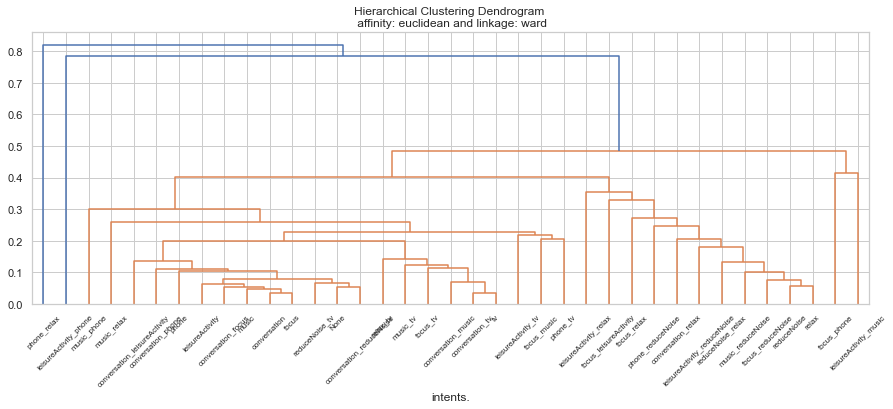

In [44]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity=affinity_choice, linkage=linkage_choice)

model = model.fit(X)
labelList = list(np.unique(np.asarray(data.intents)))

plt.figure(figsize=(15,5))
plt.title('Hierarchical Clustering Dendrogram \n affinity: {} and linkage: {}'.format(affinity_choice, linkage_choice))
# plot dendrogram
# add to only show top 3 levels: , truncate_mode='level', p=3
plot_dendrogram(model, labels=labelList)
plt.xlabel("intents.")
filename = 'dendrogram_intents_' + 'affinity_' + affinity_choice + '_linkage_' + linkage_choice +'.png'
plt.savefig(filename)
plt.show()